In [ ]:
# Quick Swin-UNETR Inference Test Notebook
# Run this in a Jupyter notebook or Python script

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import zarr
from omegaconf import DictConfig, OmegaConf
from hydra.utils import instantiate

# ============================================================================
# 1. SETUP PATHS
# ============================================================================
CHECKPOINT_DIR = Path("/clusterfs/nvme/segment_3d/tests/supervised_models/test_swin_unetr_reproducibility/checkpoints/latest_model")
CHECKPOINT_FILE = CHECKPOINT_DIR / "zero_pp_rank_0_mp_rank_00_model_states.pt"

# Path to a test zarr file (you'll need to point this to an actual test sample)
# Example: from your database or a saved test sample
TEST_ZARR_PATH = None  # Set this to a path like "/path/to/test_sample.zarr"


In [ ]:

# ============================================================================
# 2. LOAD MODEL CONFIG AND INSTANTIATE MODEL
# ============================================================================
# Load the model config
model_cfg = OmegaConf.create({
    "_target_": "cell_observatory_finetune.models.meta_arch.swin_unetr.FinetuneSwinUNETR",
    "input_fmt": "ZYXC",
    "input_shape": [128, 128, 128, 2],
    "patch_shape": [2, 2, 2, None],
    "model_template": "swin-unetr-base",
    "task": "boundary_segmentation",
    "output_channels": 1,
})

model = instantiate(model_cfg)
model.eval()


In [ ]:

# ============================================================================
# 3. LOAD CHECKPOINT
# ============================================================================
print(f"Loading checkpoint from: {CHECKPOINT_FILE}")
checkpoint = torch.load(CHECKPOINT_FILE, map_location="cpu")

# Extract state dict (handle different checkpoint formats)
state_dict = None
for key in ["module", "state_dict", "model", "model_state_dict"]:
    if key in checkpoint and isinstance(checkpoint[key], dict):
        state_dict = checkpoint[key]
        break

if state_dict is None:
    # Try direct dict
    state_dict = checkpoint

# Load into model (handle DeepSpeed wrapper if present)
model_module = model.module if hasattr(model, "module") else model
missing, unexpected = model_module.load_state_dict(state_dict, strict=False)
print(f"Missing keys: {len(missing)}")
print(f"Unexpected keys: {len(unexpected)}")

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model loaded on {device}")


In [ ]:

# ============================================================================
# 4. LOAD TEST DATA
# ============================================================================
# Option A: Load from zarr file directly
if TEST_ZARR_PATH and Path(TEST_ZARR_PATH).exists():
    zarr_group = zarr.open(TEST_ZARR_PATH, mode='r')
    # Assuming data is in '0' or similar key
    data_key = '0' if '0' in zarr_group else list(zarr_group.keys())[0]
    data = zarr_group[data_key][:]  # Shape: (Z, Y, X, C) or similar
    print(f"Loaded data shape: {data.shape}")
else:
    # Option B: Create dummy test data
    print("Creating dummy test data (128, 128, 128, 2)")
    data = np.random.randn(128, 128, 128, 2).astype(np.float16)
    # Normalize to reasonable range
    data = (data - data.min()) / (data.max() - data.min()) * 255
    data = data.astype(np.uint16)

# Ensure data is in ZYXC format
if data.ndim == 4 and data.shape[-1] == 2:
    # Already ZYXC
    pass
else:
    raise ValueError(f"Unexpected data shape: {data.shape}, expected (Z, Y, X, C)")


In [ ]:

# ============================================================================
# 5. PREPROCESSING
# ============================================================================
# Simple preprocessing (matching swin_unetr_preprocessor.yaml)
# For inference, we skip augmentation transforms

# Convert to torch tensor
data_tensor = torch.from_numpy(data).float()  # (Z, Y, X, C)

# Normalize (simple min-max normalization per channel)
for c in range(data_tensor.shape[-1]):
    channel = data_tensor[..., c]
    channel_min, channel_max = channel.min(), channel.max()
    if channel_max > channel_min:
        data_tensor[..., c] = (channel - channel_min) / (channel_max - channel_min)

# Add batch dimension: (1, Z, Y, X, C)
data_tensor = data_tensor.unsqueeze(0)

# Move to device
data_tensor = data_tensor.to(device)

# Create data_sample dict (format expected by model)
data_sample = {
    'data_tensor': data_tensor,
    'metainfo': {}
}

print(f"Preprocessed data shape: {data_tensor.shape}")


In [ ]:

# ============================================================================
# 6. RUN INFERENCE
# ============================================================================
print("Running inference...")
with torch.no_grad():
    # Model expects data_sample dict
    output = model.predict(data_sample)  # or model.forward(data_sample)

# Output shape depends on model - typically (B, C, Z, Y, X) or (B, Z, Y, X, C)
print(f"Output shape: {output.shape}")

# Convert to numpy for visualization
if isinstance(output, torch.Tensor):
    output_np = output.cpu().numpy()
else:
    output_np = output

# Remove batch dimension if present
if output_np.ndim == 5:
    output_np = output_np[0]  # (C, Z, Y, X) or (Z, Y, X, C)


In [ ]:

# ============================================================================
# 7. VISUALIZE
# ============================================================================
# Determine channel dimension
if output_np.shape[0] < 10:  # Likely (C, Z, Y, X)
    C, Z, Y, X = output_np.shape
    z_mid = Z // 2
    boundary_pred = output_np[0, z_mid] if C >= 1 else output_np[0, z_mid]
    if C >= 2:
        cell_pred = output_np[1, z_mid]
    else:
        cell_pred = None
elif output_np.shape[-1] < 10:  # Likely (Z, Y, X, C)
    Z, Y, X, C = output_np.shape
    z_mid = Z // 2
    boundary_pred = output_np[z_mid, ..., 0] if C >= 1 else output_np[z_mid]
    if C >= 2:
        cell_pred = output_np[z_mid, ..., 1]
    else:
        cell_pred = None
else:  # Assume (Z, Y, X) single channel
    Z, Y, X = output_np.shape
    z_mid = Z // 2
    boundary_pred = output_np[z_mid]
    cell_pred = None

# Visualize
fig, axes = plt.subplots(1, 3 if cell_pred is not None else 2, figsize=(15, 5))

# Input (middle slice, first channel)
input_slice = data_tensor[0, z_mid, :, :, 0].cpu().numpy()
axes[0].imshow(input_slice, cmap='gray')
axes[0].set_title('Input (Z={})'.format(z_mid))
axes[0].axis('off')

# Boundary prediction
axes[1].imshow(boundary_pred, cmap='hot')
axes[1].set_title('Boundary Prediction')
axes[1].axis('off')

# Cell prediction (if available)
if cell_pred is not None:
    axes[2].imshow(cell_pred, cmap='viridis')
    axes[2].set_title('Cell Prediction')
    axes[2].axis('off')

plt.tight_layout()
plt.savefig('swin_unetr_test_prediction.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved to: swin_unetr_test_prediction.png")

In [4]:
# Load tiff file
from tifffile import imread
from pathlib import Path
tiff_path = Path("/clusterfs/nvme/segment_3d/tests/supervised_models/test_inference_swin_unetr/inference/pred_inference_roi166_000x_000y_000z_predictions.tiff")
tiff_data = imread(tiff_path)

# Convert to numpy
tiff_data.shape


(1, 128, 896, 1536)

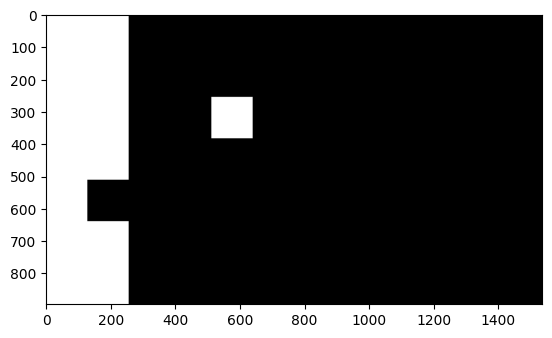

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Plot max projection, renorm all values via softmax
sm = np.exp(tiff_data[0])
sm = sm / sm.sum()
plt.imshow(sm[64, :, :], cmap="gray")
plt.show()



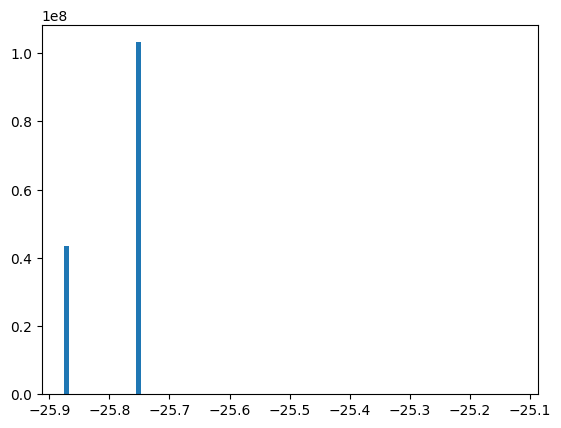

In [18]:
# plot pixel intensity histogram where values are >0
data = tiff_data[0].flatten()
new_data = data[data < 0]
plt.hist(new_data, bins=100)
plt.show()

In [17]:
new_data

array([], dtype=float32)

In [23]:
sm

array([[[3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         2.5318967e-19, 2.5318967e-19, 3.6838879e-19],
        [3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         1.9718428e-19, 1.9718428e-19, 2.5318967e-19],
        [3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         1.9718428e-19, 2.2343909e-19, 2.5318967e-19],
        ...,
        [3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         2.2343909e-19, 2.2343909e-19, 2.5318967e-19],
        [3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         2.2343909e-19, 2.2343909e-19, 2.5318967e-19],
        [3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         2.5318967e-19, 2.5318967e-19, 3.2510196e-19]],

       [[3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         2.2343909e-19, 2.2343909e-19, 2.5318967e-19],
        [3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         1.9718428e-19, 2.2343909e-19, 2.2343909e-19],
        [3.4059799e-08, 3.4059799e-08, 3.4059799e-08, ...,
         2.234

In [1]:
# Convert script: convert_tiff_to_32bit.py
import tifffile
from pathlib import Path

def convert_tiff_to_32bit(input_path, output_path):
    """Convert 64-bit TIFF to 32-bit float."""
    img = tifffile.imread(input_path)
    # Convert to float32
    img_32bit = img.astype('float32')
    tifffile.imwrite(output_path, img_32bit, compression='zlib')

# Convert all files
images_dir = Path("/clusterfs/nvme/segment_3d/tests/datasets/CellSeg3D_mesoSPIM/prepared/images")
labels_dir = Path("/clusterfs/nvme/segment_3d/tests/datasets/CellSeg3D_mesoSPIM/prepared/labels")
output_images = Path("/clusterfs/nvme/segment_3d/tests/datasets/CellSeg3D_mesoSPIM/prepared_32bit/images")
output_labels = Path("/clusterfs/nvme/segment_3d/tests/datasets/CellSeg3D_mesoSPIM/prepared_32bit/labels")
output_images.mkdir(parents=True, exist_ok=True)
output_labels.mkdir(parents=True, exist_ok=True)

for img_file in images_dir.glob("*.tif"):
    convert_tiff_to_32bit(img_file, output_images / img_file.name)

for lab_file in labels_dir.glob("*.tif"):
    convert_tiff_to_32bit(lab_file, output_labels / lab_file.name)

In [2]:
# Load tiff file
from tifffile import imread
from pathlib import Path
tiff_path = Path("/clusterfs/nvme/segment_3d/tests/outputs/inference_results/c3image_SwinUNetR_pred_3_2025_11_28_17_40_31.tif")
tiff_data = imread(tiff_path)

# Convert to numpy
tiff_data.shape

(299, 105, 147)

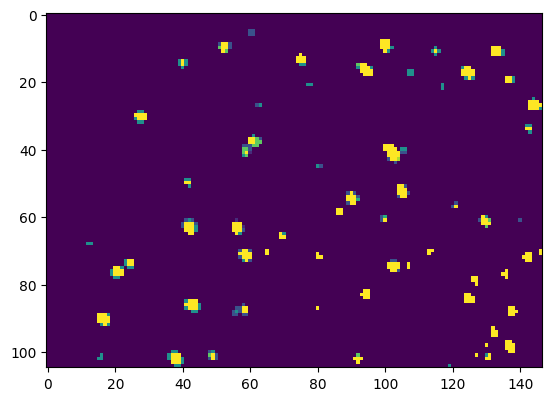

In [4]:
import matplotlib.pyplot as plt
plt.imshow(tiff_data[100])
plt.show()
